In [18]:
import torch
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import torchvision.utils
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import itertools
import time

# from progressbar import progressbar as pb

In [20]:
# FOR DEBUG PURPOSES
class Timer:
    def __init__(self, msg):
        self.msg = msg
        
    def __enter__(self):
        torch.cuda.synchronize()
        self.start = time.process_time()
        return self

    def __exit__(self, *args):
        torch.cuda.synchronize()
        self.end = time.process_time()
        self.interval = self.end - self.start
        
        print('{}: {:.5f}'.format(self.msg, self.interval))

In [21]:
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [22]:
n_gaussian = 8  # size of latent gaussian variable
block_size = 2  # size of coordinate search blocks
n_rounds = 4  # number of coordinate search rounds 

# n_b = 0  # size of the latent binary variable
# n_o = 0  # size of the latent one-hot variable

batch_size = 64  # samples of data distribution at each iteration
latent_batch_size = np.power(32, block_size)

n_epochs = 20

In [23]:
img_size = 28  # desired resized image size
nc = 1  # number of image channels
# workers = 2  # number of workers for dataloader

In [24]:
use_cuda = torch.cuda.is_available()
gpu_ids = '2,3'
gpu_ids = [int(s) for s in gpu_ids.split(',')]
device = torch.device("cuda:{}".format(gpu_ids[0]) if use_cuda else "cpu")

# if len(gpu_ids) > 0:
#     torch.cuda.set_device(gpu_ids[0])

torch.manual_seed(42)
np.random.seed(42)

# Should the default pytorch URL may fail, edit the source code of EMNIST function and update the URL
# E.g: vim ~/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py
# Correct URL as of Jan 2020: https://cloudstor.aarnet.edu.au/plus/s/ZNmuFiuQTqZlu9W/download



dataset_mean, dataset_std = 0.1751, 0.3332
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('../data', split='balanced', train=True, download=True,
                    transform=transforms.Compose([
#                         transforms.Resize(img_size),
                        transforms.ToTensor(),
                        transforms.Normalize((dataset_mean,), (dataset_std,))
                    ])),
    batch_size=batch_size, shuffle=True, drop_last=True)


# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=batch_size, shuffle=True, drop_last=True)

In [25]:
class BlockCoordinateSearch():
    def __init__(self, batch_size, latent_batch_size, n_gaussian, n_rounds, block_size, criterion_no_reduction, device, netG):
        """
        Block coordinate grid search optimizer over the distribution of points 
        in the latent space.
        
        Args:
            criterion_no_reduction: loss function to compare, and MUST NOT have reduction.
        """
        
#         self.m = torch.distributions.multivariate_normal.MultivariateNormal(
#             torch.zeros(block_size), 
#             torch.eye(block_size))
        
        self.batch_size = batch_size
        self.latent_batch_size = latent_batch_size
        self.n_gaussian = n_gaussian
        self.block_size = block_size
        
        self.n_rounds = n_rounds
        
#         self.netG = netG
        self.criterion_no_reduction = criterion_no_reduction
        
#         if device.type == 'cuda':
#             torch.cuda.set_device(device)
#             self.torch = torch.cuda
#         else:
#             self.torch = torch
        self.device = device
        self.netG = netG
        
    def _sample_block(self, old_z, block_idx):
        """
        Takes the best codes and perturbs
        
        Args:
            old_z: batch_size x n_gaussian
        Returns:
            new_z: batch_size x latent_batch_size x n_gaussian
        """
        
#         gaussian_samples = torch.randn(self.batch_size, self.latent_batch_size, self.block_size, device=device)
        
        new_z = old_z.unsqueeze(1).repeat(1, self.latent_batch_size, 1)
        new_z[:, :, block_idx * self.block_size:(block_idx + 1) * self.block_size].normal_()
        
        return new_z
        
#     def _row_wise_repeat(mat, n_rep):
#         """
#         pytorch equivalent of numpy.repeat
#         """
#         n_rows = mat.shape[0]
#         return mat[np.arange(n_rows).repeat(n_rep), :]  # WARNING: np.repeat has a different functionality from torch.repeat

    def optimize(self, real):
        """
        Find the loss between the optimal fake data and the real data.
        
        Args:
            real: batch_size x dim_1 x ... x dim_k
            
        Returns:
            best_z: batch_size x n_gaussian
        """
        for round_idx, block_idx in itertools.product(range(self.n_rounds), range(n_gaussian // block_size)):
            if round_idx == block_idx == 0:
                best_z = torch.zeros(self.batch_size, self.n_gaussian, device=self.device)
#             # batch_size x latent_batch_size x n_gaussian
            new_z = self._sample_block(best_z, block_idx)

            if True:  # if netG is a deconv network
                # (batch_size * latent_batch_size) x n_gaussian x 1 x 1
                new_z_r = new_z.reshape(self.batch_size * self.latent_batch_size, self.n_gaussian, 1, 1)
            else:
                new_z_r = new_z.reshape(self.batch_size * self.latent_batch_size, self.n_gaussian)

            # (batch_size * latent_batch_size) x dim_1 x ... x dim_k
            torch.cuda.synchronize()
            with torch.no_grad():  # no need to store the gradients while searching
                fake_all = self.netG(new_z_r)

            # batch_size x latent_batch_size x dim_1 x ... x dim_k

            all_shape = [self.batch_size, self.latent_batch_size, *real.shape[1:]]

            # batch_size x latent_batch_size x dim_1 x ... x dim_k
            fake_all = fake_all.reshape(all_shape)
            real_all = real.unsqueeze(1).expand(all_shape)

            # batch_size x latent_batch_size x dim_1 x ... x dim_k
            loss = self.criterion_no_reduction(real_all, fake_all)

            # batch_size x latent_batch_size x -1
            loss = loss.reshape([*all_shape[:2], -1])

            # batch_size x latent_batch_size
            loss = loss.mean(dim=2)

            # batch_size
            _, argmin = loss.min(dim=1)

            # new_z: batch_size x latent_batch_size x n_gaussian
            # best_idx: batch_size x 1 x n_gaussian
            best_idx = argmin[:, None, None].repeat(1, 1, self.n_gaussian)

            # batch_size x 1 x n_gaussian
            best_z = torch.gather(new_z, 1, best_idx)

            # batch_size x n_gaussian
            best_z = best_z.squeeze()
                                            
#         x_train = latent_code_dist.sample(latent_batch_size).to(device)
#         y_train = real.repeat(latent_batch_size, 1)
        
#         y_pred = row_wise_repeat(netG(x_train), batch_size)

#         loss_all_modes = loss_fn(y_pred, y_train)
        

#         # Zero the gradients before running the backward pass.
#         optimizer.zero_grad()
        
#         selective_loss = loss_all_modes.mean(dim=1).reshape(latent_batch_size, batch_size).min(dim=0)[0].sum()
  

        return best_z

In [26]:
# # D_in is input dimension;
# # H is hidden dimension;
# # D_out is output dimension.

# D_in, H, D_out = n_gaussian, 100, 28 * 28

# netG = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, D_out),
# ).to(device)

In [27]:
ngf = 64

In [28]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, gpu_ids):
        super(Generator, self).__init__()
        self.gpu_ids = gpu_ids
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( n_gaussian, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        y = self.main(input)
        for dim in (2,3):
            y = y.narrow(dim, start=2, length=28)
        return y
    
# Create the generator
netG = Generator(gpu_ids).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (len(gpu_ids) > 1):
    netG = nn.DataParallel(netG, gpu_ids)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(8, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): Tanh()
    )
  )
)

In [29]:
optimizer = optim.Adam(netG.parameters(), betas=(0.5, 0.999))

criterion = torch.nn.L1Loss()
criterion_no_reduction = torch.nn.L1Loss(reduction='none')

bcs = BlockCoordinateSearch(batch_size, latent_batch_size, n_gaussian, n_rounds, block_size, criterion_no_reduction, device, netG)

loss_log = []

In [30]:
fixed_noise = torch.randn(64, n_gaussian, 1, 1, device=device)
img_list = []

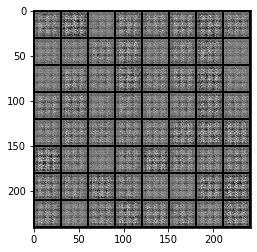

Iteration 0: 15.86958
Iteration 1: 8.26571
Iteration 2: 6.79504
Iteration 3: 6.78600
Iteration 4: 6.86666
Iteration 5: 6.81881
Iteration 6: 6.81859
Iteration 7: 6.88516
Iteration 8: 6.94493
Iteration 9: 6.93572
Iteration 10: 6.94181
Iteration 11: 6.85648
Iteration 12: 6.92584
Iteration 13: 6.97202
Iteration 14: 6.88813
Iteration 15: 6.92210
Iteration 16: 6.92925
Iteration 17: 7.00334
Iteration 18: 6.97563
Iteration 19: 6.95874
Iteration 20: 6.61970
Iteration 21: 6.18050
Iteration 22: 6.17196
Iteration 23: 6.08945
Iteration 24: 6.29711
Iteration 25: 7.01108
Iteration 26: 7.05095
Iteration 27: 6.99025
Iteration 28: 6.53259
Iteration 29: 6.13594
Iteration 30: 6.16786
Iteration 31: 6.19703
Iteration 32: 6.57837
Iteration 33: 7.02823
Iteration 34: 6.93631
Iteration 35: 7.04834
Iteration 36: 7.03992
Iteration 37: 6.96838
Iteration 38: 6.94392
Iteration 39: 7.04823
Iteration 40: 7.01676
Iteration 41: 6.88387
Iteration 42: 7.07354
Iteration 43: 6.99694
Iteration 44: 7.08494
Iteration 45: 6.998

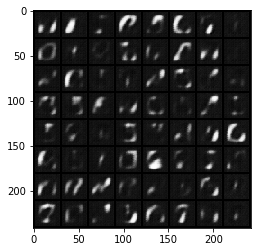

Iteration 50: 14.77292
Iteration 51: 7.72550
Iteration 52: 6.90427
Iteration 53: 7.08265
Iteration 54: 7.04638
Iteration 55: 7.03959
Iteration 56: 7.03472
Iteration 57: 7.11379
Iteration 58: 7.02467
Iteration 59: 7.01563
Iteration 60: 7.05364
Iteration 61: 7.05945
Iteration 62: 7.12866
Iteration 63: 7.11492
Iteration 64: 6.91802
Iteration 65: 7.06165
Iteration 66: 7.00663
Iteration 67: 7.04041
Iteration 68: 7.01723
Iteration 69: 6.98343
Iteration 70: 7.07111
Iteration 71: 6.20675
Iteration 72: 6.21140
Iteration 73: 6.15191
Iteration 74: 6.23444
Iteration 75: 7.01019
Iteration 76: 7.02810
Iteration 77: 7.05325
Iteration 78: 6.58890
Iteration 79: 6.21320
Iteration 80: 6.22803
Iteration 81: 6.22551
Iteration 82: 6.53597
Iteration 83: 6.97025
Iteration 84: 7.01308
Iteration 85: 7.09995
Iteration 86: 7.07622
Iteration 87: 7.00261
Iteration 88: 7.08507
Iteration 89: 6.99547
Iteration 90: 6.93016
Iteration 91: 6.93341
Iteration 92: 7.04100
Iteration 93: 6.96686
Iteration 94: 7.05868
Iteration

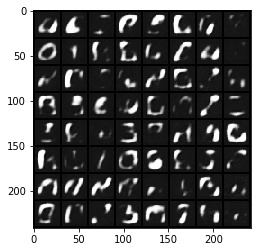

Iteration 100: 13.06254
Iteration 101: 8.43792
Iteration 102: 7.01591
Iteration 103: 7.05901
Iteration 104: 7.04824
Iteration 105: 7.00120
Iteration 106: 7.02970
Iteration 107: 6.99129
Iteration 108: 7.00333
Iteration 109: 7.05183
Iteration 110: 6.98169
Iteration 111: 7.06699
Iteration 112: 6.93019
Iteration 113: 7.07403
Iteration 114: 6.99786
Iteration 115: 7.04807
Iteration 116: 7.00638
Iteration 117: 6.96978
Iteration 118: 7.02304
Iteration 119: 6.95744
Iteration 120: 7.04665
Iteration 121: 6.78955
Iteration 122: 6.18626
Iteration 123: 6.23187
Iteration 124: 6.18728
Iteration 125: 6.20027
Iteration 126: 7.04666
Iteration 127: 7.07305
Iteration 128: 7.04485
Iteration 129: 6.29667
Iteration 130: 6.18434
Iteration 131: 6.22878
Iteration 132: 6.23552
Iteration 133: 6.82767
Iteration 134: 7.02654
Iteration 135: 6.98203
Iteration 136: 7.01651
Iteration 137: 7.02532
Iteration 138: 7.06332
Iteration 139: 7.05725
Iteration 140: 7.00525
Iteration 141: 7.06949
Iteration 142: 6.93746
Iteration 

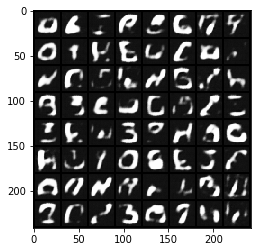

Iteration 150: 14.08752
Iteration 151: 8.36670
Iteration 152: 7.08640
Iteration 153: 7.07369
Iteration 154: 6.98904
Iteration 155: 7.04854
Iteration 156: 6.91772
Iteration 157: 7.05076
Iteration 158: 7.04159
Iteration 159: 7.10963
Iteration 160: 7.04286
Iteration 161: 7.01654
Iteration 162: 7.07399
Iteration 163: 6.96720
Iteration 164: 7.01428
Iteration 165: 6.96123
Iteration 166: 7.02143
Iteration 167: 7.03165
Iteration 168: 6.94351
Iteration 169: 6.97761
Iteration 170: 6.90283
Iteration 171: 6.95490
Iteration 172: 6.92846
Iteration 173: 6.19434
Iteration 174: 6.22468
Iteration 175: 6.14893
Iteration 176: 6.22316
Iteration 177: 6.97698
Iteration 178: 7.01959
Iteration 179: 6.97004
Iteration 180: 6.28706
Iteration 181: 6.16381
Iteration 182: 6.21671
Iteration 183: 6.18099
Iteration 184: 6.41142
Iteration 185: 6.96692
Iteration 186: 6.88896
Iteration 187: 6.93890
Iteration 188: 6.97031
Iteration 189: 6.90557
Iteration 190: 6.97250
Iteration 191: 6.91165
Iteration 192: 6.90553
Iteration 

In [ ]:
for epoch in range(1, n_epochs + 1):
    current_epoch_losses = []
    
    for iters, (data, _) in enumerate(train_loader):            
        with Timer('Iteration %d'%iters):
            # batch_size x dim_1 x ... x dim_k
            real = data.to(device)

            if True:  # if EMNIST!!
                real = real.transpose(2, 3)

            torch.backends.cudnn.benchmark=True  # temporary speed-up
            netG.eval()

            # batch_size x n_gaussian
            best_z = bcs.optimize(real)
            
            netG.train()
            torch.backends.cudnn.benchmark=False


            if True:
                best_z = best_z.reshape(batch_size, n_gaussian, 1, 1)

            # batch_size x dim_1 x ... x dim_k
            fake = netG(best_z)

    #         x_train = latent_code_dist.sample(latent_batch_size).to(device)
    #         y_train = real.repeat(latent_batch_size, 1)

    #         y_pred = row_wise_repeat(netG(x_train), batch_size)

    #         loss_all_modes = loss_fn(y_pred, y_train)

            # in case we are predicting images with a fully connected net, we have to give it appropriate width and height!
            fake = fake.reshape(real.shape)
            loss = criterion(real, fake)
            # Zero the gradients before running the backward pass.
            optimizer.zero_grad()
    #         selective_loss = loss_all_modes.mean(dim=1).reshape(latent_batch_size, batch_size).min(dim=0)[0].sum()
            loss.backward()        

            current_epoch_losses.append(loss)

            optimizer.step()

            if iters % 50 == 0:
                with torch.no_grad():
                    netG.eval()
                    fake = netG(fixed_noise).detach().cpu()
                    netG.train()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                plt.imshow(img_list[-1].numpy().transpose(1,2,0))
                plt.show()
    
    loss_log.append(torch.tensor(current_epoch_losses).mean().detach().numpy())
    
    if True:  # if epoch % 10 == 0:
        print('Epoch: {} / Loss: {:.2f}'.format(epoch, loss_log[-1]) + '\n' + '=' * 22 + '\n')

In [ ]:
plt.figure()
plt.title('Loss vs Epochs Passed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_log)), loss_log)
plt.show()

In [ ]:
netG.eval()

In [ ]:
grid_width = 8

x1 = np.linspace(0.02, 0.98, grid_width)
x2 = np.linspace(0.02, 0.98, grid_width)
x1, x2 = norm.ppf(x1), norm.ppf(x2)  # apply inverse normal cdf to distribute codes equally across the distribution

xv1, xv2 = np.meshgrid(x1, x2)
xv1, xv2 = xv1.reshape(-1, 1), xv2.reshape(-1, 1)

y_pred = data.cpu()
y_pred = y_pred.transpose(3,2)

img = torchvision.utils.make_grid(y_pred, nrow=grid_width, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)

plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off') 

plt.show()

In [ ]:
from scipy.stats import norm
import cv2 as cv

grid_width = 8

if True:
    x_test = torch.randn(grid_width * grid_width, n_gaussian, 1, 1, device=device)
else:
    x_test = torch.randn(grid_width * grid_width, n_gaussian, device=device)

y_pred = netG(x_test).detach().cpu().reshape(-1, 1, img_size, img_size)
# y_pred = y_pred.transpose(3,2)

img = torchvision.utils.make_grid(y_pred, nrow=grid_width, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)

plt.figure()
plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off') 
                            
plt.show()


In [ ]:
from scipy.stats import norm
import cv2 as cv

grid_width = 4
x1 = np.linspace(0.02, 0.98, grid_width)
x1 = norm.ppf(x1)

xv_list = np.meshgrid(*([x1] * 8))
xv_list = [xv.reshape(-1, 1) for xv in xv_list]

x_test = torch.from_numpy(np.hstack(xv_list)).float().to(device)

y_pred = data.cpu()
y_pred = torch.cat([netG(x_test[(128*i):(128*(i+1)),:,None,None]).detach().cpu() for i in range(len(x_test)//128)]).reshape(-1, 1, img_size, img_size)
# y_pred = y_pred.transpose(3,2)

nrow = int(np.sqrt(len(y_pred)))
img = torchvision.utils.make_grid(y_pred, nrow=nrow, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(nrow, nrow), dpi=img_size)
plt.imshow(np.transpose(img, (1,2,0)))
plt.axis('off') 
                            
# plt.show()
plt.savefig('./fig.png')

# like a fedback network while searching

In [ ]:
!ls '/home/arash/Desktop/celeba/img_align_celeba/' | wc -l